#Task

1. **Text preprocessing**
  
  a. There are several extra data resources for this competition. You may investigate them also. The most frequently used are the base data and the translated data. Some pre-trained models are also available in Kaggle “public datasets”.

  b. For some models preprocessing may be needed. Please, perform at least the following steps (in preferred order):

     -  Stop-words removing

     -  Processing of numbers and service characters

     -  Register processing

     -  Text normalisation

     -  Dictionary-based processing of informal speech

2. **Embeddings with any preferred classification model** (mandatory are in cursive)

  a. *tf-idf (start with this),*

  b. *word2vec from gensim or spacy,*

  c. fasttext from its native lib or from gensim,

  d. doc2vec from gensim,

  e. Starspace,

  f. *pre-trained BERT in preferred framework*,

  g. *Fine-tune preferred language model*,

  h. Use an ensemble of all models used.

3. **Metric: ROC_AUC**


**Notes:**

All embeddings may be used with pre-trained weights or vectors

You are not limited with the models described above – you can utilise all the models listed in the materials

Check the baseline and beat the score of 0.91

# Preluminaries

Итак, чтобы не мучаться несколько раз, мы сделаем EDA единожды и будем работать во всех последующих моделях с уже обработанными данными.

Так как это не первая итерация дз, было бы интересно посмотреть, а как результаты будут менятся в зависимости от были ли данные почищены (spellcheck) или нет.

Дело в том, что во время подготовки, я заметила, что далеко не всегда спелчек хорошо срабатывает на неформальной речи. Часто сильно меняет значение. Но размер словаря при применении спелчека существенно уменьшался. Поэтому решила попробовать.

Ну и будем делать TF-IDF BPEmb. Как показал опыт, он дает наилучшие результаты.

Также опыт показал, что наилучшие результаты дает еще спелчек+лемматизация, а также комбинация tf-idf bpemb + tf-idf words. Но на большом датасете мы не будем такого творить. Разница в скорах слишком небольшая получается, чтобы так загоняться.


# Imports

In [ ]:
!pip install bpemb

     |████████████████████████████████| 1.2MB 10.0MB/s 


In [ ]:
#basic package
import numpy as np
import pandas as pd

#feature engineering
from gensim import utils
import gensim.parsing.preprocessing as gsp
from sklearn.feature_extraction.text import TfidfVectorizer
from bpemb import BPEmb
from sklearn.pipeline import make_union
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

#vizualiazation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'
from wordcloud import WordCloud, STOPWORDS

#settings
import os
import gc
plt.rcParams['figure.figsize'] = 10, 8
import warnings 
warnings.filterwarnings('ignore')

from google_drive_downloader import GoogleDriveDownloader as gdd

# Auxilliary functions

In [ ]:
def lst_to_str(lst):
    str = ''
    for element in lst:
         str += element

    return str

In [ ]:
def normalized_confusion_matrix (y, predictions):
    '''
    Функция для построения confusion_matrix.
    y - истинные значения
    predictions - предсказанные значения
    '''
    conf = confusion_matrix(y, predictions, normalize = 'true')
    sns.heatmap(conf,
                annot=conf/np.sum(conf,axis=1), #normalized by true class sizes
                yticklabels=['Pred. Pos', 'Pred. Neg.'],
                xticklabels=['True Positive', 'True Negative'],  
                cmap= 'Blues');
    plt.title('Logistic regression confusion matrix');
    plt.xlabel('Predicted label');
    plt.ylabel('True label');

# EDA & DP

[EDA и data preparation тут](https://colab.research.google.com/drive/1RUvUuLHinTWeSZcpzQZlilaSCFGCprpC?usp=sharing)

# TF-IDF with cleaning (Spell-check)

## Download & Overview

Загрузим данные со спелчеком

In [ ]:
gdd.download_file_from_google_drive(file_id='1jP3ZOQpLIf1mYh_N_Q5p50XDe22su3aP',\
                                    dest_path='/Data/train.csv')
train = pd.read_csv('/Data/train.csv')

In [ ]:
train.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
train.shape

(1340101, 3)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340101 entries, 0 to 1340100
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   comment_text  1340101 non-null  object
 1   toxic         1340101 non-null  int64 
 2   lang          1340101 non-null  object
dtypes: int64(1), object(2)
memory usage: 30.7+ MB


Ранее мы не удалили в EDA дубли. Сделаем это сейчас.

In [ ]:
train[train.duplicated()]

,comment_text,toxic,lang
1553,['juillet etc'],0,fr
2017,['juillet etc'],0,fr
2211,[''],0,fr
2399,[''],0,fr
2819,['juillet etc'],0,fr
...,...,...,...
1339778,"['добро пожаловать', 'здравствуйте добро пожал...",0,ru
1339794,['заткнись'],1,ru
1339807,"['спасибо эксперимент википедией', 'ваш тест с...",0,ru
1339966,"['пожалуйста остановись', 'продолжите вандализ...",0,ru


Дубли есть. Удалим их.

In [ ]:
train.drop_duplicates(keep='first', inplace=True, ignore_index=True)

In [ ]:
%%time
train['comment_text'] = train['comment_text'].apply(lambda row: eval(row))

CPU times: user 20.7 s, sys: 925 ms, total: 21.6 s
Wall time: 21.7 s


В принципе, разбивка на предложения внутри списка нам больше в tf-idf не нужна. Сделаем все одной строкой.

In [ ]:
%%time
train['comment_text'] = train['comment_text'].apply(lambda row: lst_to_str(row))

CPU times: user 1.95 s, sys: 10.8 ms, total: 1.96 s
Wall time: 1.97 s


In [ ]:
train.head(5)

,comment_text,toxic,lang
0,hé mec essaye vraiment modifier guerretype sup...,0,fr
1,félicitations part également utilisez bien out...,0,fr
2,point mitsurugi sens plaider inclure hindi pag...,0,fr
3,plus peux véritables suggestions amélioration ...,0,fr
4,alignement contraires dulithgow,0,fr


## Train-test-split

In [ ]:
X = train.comment_text
y = train.toxic

In [ ]:
del train
gc.collect()

214

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
print ('Train set:', X_train.shape)
print ('Test set:', X_test.shape)

Train set: (928433,)
Test set: (397900,)


## TF-IDF

In [ ]:
from bpemb import BPEmb

In [ ]:
multibpemb = BPEmb(lang="multi", vs=1000000, dim=300)

downloading https://nlp.h-its.org/bpemb/multi/multi.wiki.bpe.vs1000000.model


100%|██████████| 20636145/20636145 [00:01<00:00, 10503292.93B/s]


downloading https://nlp.h-its.org/bpemb/multi/multi.wiki.bpe.vs1000000.d300.w2v.bin.tar.gz


100%|██████████| 1123372891/1123372891 [01:02<00:00, 18108662.35B/s]


In [ ]:
tfidf_bpemb = TfidfVectorizer(
                              analyzer=multibpemb.encode, 
                              token_pattern=r'\w{1,}',
                              strip_accents = 'unicode',
                              ngram_range = (1, 2),
                              sublinear_tf = True, 
                              max_features = 100000
                              )

In [ ]:
%%time

X_train = tfidf_bpemb.fit_transform(X_train)
X_test = tfidf_bpemb.transform(X_test)

CPU times: user 8min 34s, sys: 2.44 s, total: 8min 37s
Wall time: 8min 38s


## Logreg

In [ ]:
%%time

parameters = {'C': [0.1, 0.5, 1, 5],
              'penalty': ['l1', 'l2', 'elasticnet']}

grid_search = GridSearchCV(LogisticRegression(class_weight = 'balanced'), param_grid=parameters,
                           cv=StratifiedKFold(3), scoring='roc_auc', verbose=2)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] C=0.1, penalty=l1 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ................................ C=0.1, penalty=l1, total=   0.2s
[CV] C=0.1, penalty=l1 ...............................................
[CV] ................................ C=0.1, penalty=l1, total=   0.1s
[CV] C=0.1, penalty=l1 ...............................................
[CV] ................................ C=0.1, penalty=l1, total=   0.1s
[CV] C=0.1, penalty=l2 ...............................................
[CV] ................................ C=0.1, penalty=l2, total=  21.8s
[CV] C=0.1, penalty=l2 ...............................................
[CV] ................................ C=0.1, penalty=l2, total=  27.5s
[CV] C=0.1, penalty=l2 ...............................................
[CV] ................................ C=0.1, penalty=l2, total=  28.0s
[CV] C=0.1, penalty=elasticnet .......................................
[CV] ........................ C=0.1, penalty=elasticnet, total=   0.1s
[CV] C=0.1, penalty=elasticnet .......................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  6.2min finished


CPU times: user 7min 48s, sys: 5min 7s, total: 12min 56s
Wall time: 6min 59s


In [ ]:
best_parameters = grid_search.best_params_
print ('best parameters:', best_parameters)

best parameters: {'C': 1, 'penalty': 'l2'}


In [ ]:
model = grid_search.best_estimator_

In [ ]:
logreg_pred = model.predict(X_test)
logreg_score = roc_auc_score(y_test, logreg_pred)
print('roc_auc_score :', logreg_score)

roc_auc_score : 0.8906235325031391


Заметим, что в прошлом дз, где мы включали английский в рассмотрение, скор на кросс-валидации был повыше. Это логично. Ведь английский вносил некоторое "положительное" смещение. Теперь же его в датасете нет.

In [ ]:
print('Test data')
print(classification_report(y_test, logreg_pred))

Test data
              precision    recall  f1-score   support

           0       0.98      0.93      0.95    359739
           1       0.55      0.86      0.67     38161

    accuracy                           0.92    397900
   macro avg       0.77      0.89      0.81    397900
weighted avg       0.94      0.92      0.93    397900



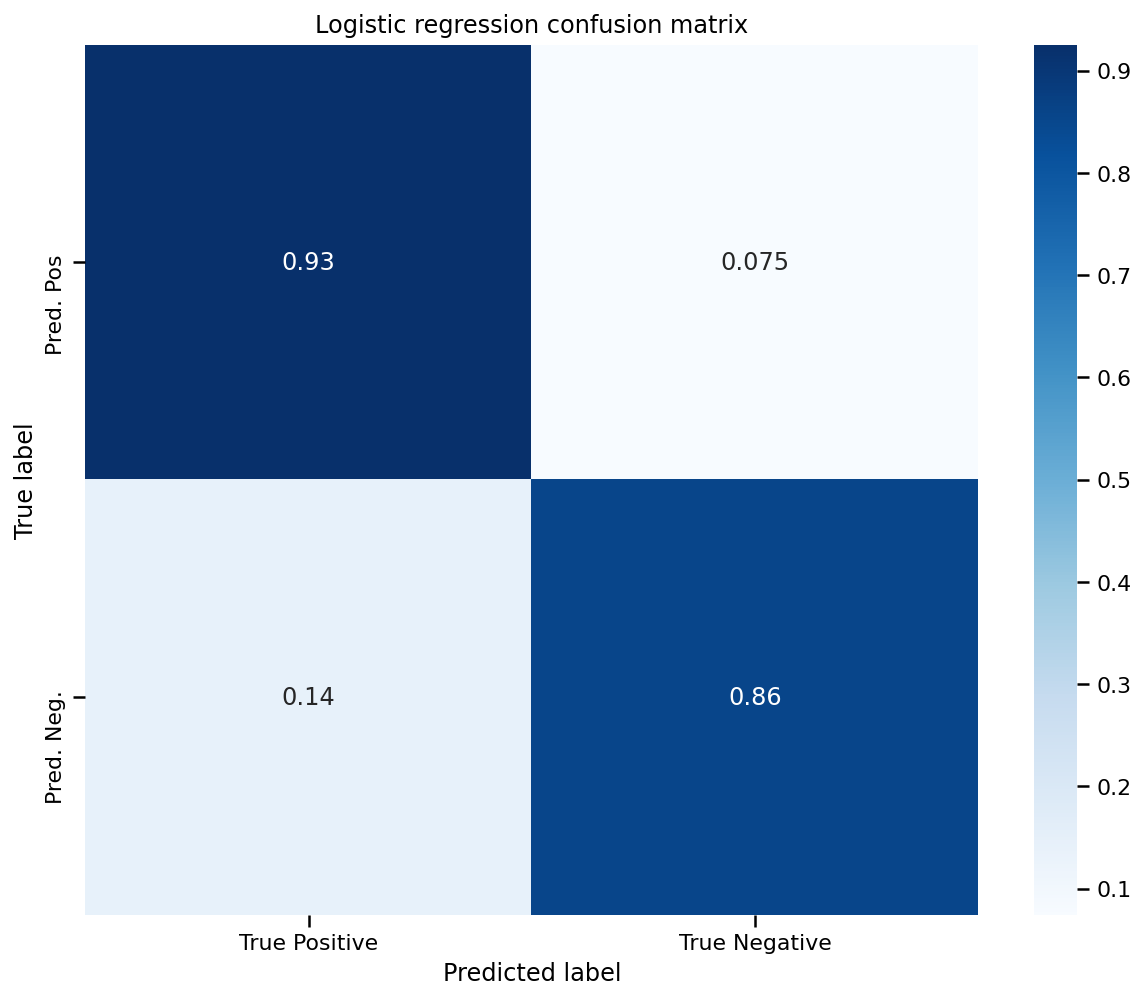

In [ ]:
normalized_confusion_matrix (y_test, logreg_pred)

##Submission

In [ ]:
def save_submission(pred):
    pd.Series(
        pred, name='toxic', index=pd.Index(range(len(pred)), name='id')
    ).to_csv('notebook_submission_tfidf_final.csv')

In [ ]:
gdd.download_file_from_google_drive(file_id='19GL4B5TVJX44K2Hibj7YYCNcLpDwTcx3',\
                                    dest_path='/Data/test.csv')
test = pd.read_csv('/Data/test.csv')
test = test.rename(columns={'content': 'comment_text'})

In [ ]:
test.head(5)

,Unnamed: 0,comment_text,lang
0,0,['doctor who adlı viki başlığına doctor olarak...,tr
1,1,['вполне возможно пока видеть необходимость вы...,ru
2,2,"['conservativi preferiscono cancellare', 'ok l...",it
3,3,['malesef gerçekleştirilmedi ancak şöyle şey v...,tr
4,4,['resim seldabagcan jpg resminde kaynak sorunu...,tr


In [ ]:
%%time

test['comment_text'] = test['comment_text'].apply(lambda row: eval(row))

CPU times: user 1.06 s, sys: 6.08 ms, total: 1.06 s
Wall time: 1.07 s


In [ ]:
%%time

test['comment_text'] = test['comment_text'].apply(lambda row: lst_to_str(row))

CPU times: user 126 ms, sys: 1.08 ms, total: 127 ms
Wall time: 126 ms


In [ ]:
test = test.comment_text

In [ ]:
test = tfidf_bpemb.transform(test)

In [ ]:
logreg_pred = model.predict(test)

In [ ]:
save_submission(logreg_pred)

И что же кэгль?

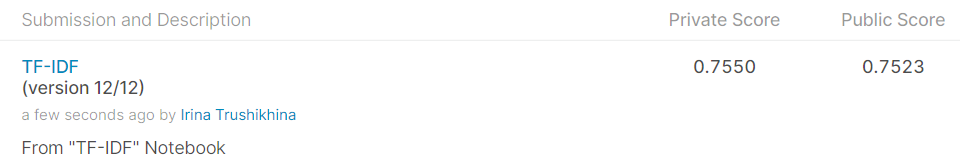

Идея использовать class-weighted знатно улучшила результат.)

Он бы улучшился еще больше, если бы была проведена лемматизация, а также, если бы мы рассматривали каждый язык в отдельности.

Посмотрим, каков результат будет без спелчека

#**Выводы:**



1. Если есть возможность сделать лемматизацию, ее лучше сделать. Она приносит значимое улучшение даже на маленьком датасете.

2. Влияние спелчека не особо значительно, но есть

3. BPEmb эффективнее просто применения TF-IDF words или TF-IDF ngrams. Но чуть лучше отрабатывает комбинация двух из них.

4. Очевидно, что результаты решения "в лоб" весьма жалки и мало интересны. Наивное применение базовых методов не дает нужного результата. Отсюда есть два пути: либо добавлять фичи, либо менять подход, основной метод. А лучше разделить языки, чтобы не было смещения.

Что мы и сделаем в следующей части дз.